In [1]:
import torch
from attention_utils import show_heatmaps
from seq2seq_models import Seq2SeqEncoder, Seq2Seq
from transformer_model import Seq2SeqAttentionDecoder
from language_model_utils import MTFraEng, bleu
from utils import Trainer

In [2]:
data = MTFraEng(batch_size=128)

Final Train Loss: 0.8877


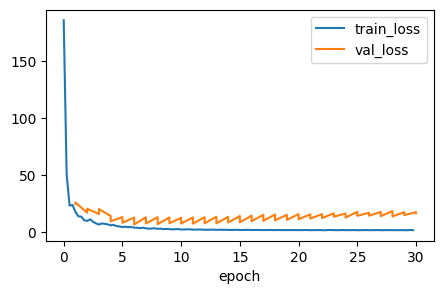

In [3]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Model validation
Translate a few English sentences into French and compute their BLEU scores

In [4]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
device = "cuda" if torch.cuda.is_available() else "cpu"

preds, _ = model.predict_step(
    data.build(engs, fras), device, data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['en', 'route', '!'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '!'], bleu,0.000
i'm home . => ['je', 'suis', '<unk>', '.'], bleu,0.512


## Summarizing
From the below heatmap we can see that at each decoding step different parts of the input sequences are selectively aggregated in the attention pooling.

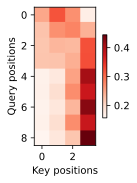

In [5]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), device, data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')